In [11]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

from utils import compute_score_bounds
from agent import Agent


class AgentDistribution:
    """This is a class for representing a distribution over a finite number of agents.
    
    Keyword arguments:
    n -- number of agents in distribution
    d -- dimension of agent
    n_types -- number of agent types
    types -- optional argument: a dictionary of agent types of the form 
        {etas: (n_types x D x 1), gammas: (n_types x D x1)}
    
    """
    def __init__(self, n=1000, d=2, n_types=50, types=None, prop=None):
        self.n = n
        self.d = d
        self.n_types = n_types
        self.types = types
        self.prop = prop
        if not types:
            #Generate n_types agent types randomly
            etas = np.random.uniform(0., 0.3, size=n_types * d).reshape(n_types, d, 1)
            gammas = np.random.uniform(2., 4., size=n_types *d).reshape(n_types, d, 1)
        else:
            etas = types["etas"]
            gammas = types["gammas"]
        if not prop:
            self.prop = np.ones(n_types) * (1/n_types)
        else:
            self.prop = prop
        np.testing.assert_allclose(np.sum(self.prop), 1.)
        
        #Create representative agents
        self.agents = []
        for i in range(n_types):
            self.agents.append(Agent(etas[i], gammas[i]))
    
    def best_response_distribution(self, beta, s, sigma):
        """This is a method that returns the best response of each agent type to a model and threshold.
        
        Keyword arguments:
        beta -- model parameters
        s -- threshold
        sigma -- standard deviation of noise distribution
        
        Returns:
        br -- a list of np.arrays
        """
        br = []
        for agent in self.agents:
            br.append(agent.best_response(s, beta, sigma))
        return br
    
    def best_response_score_distribution(self, beta, s, sigma):
        """This is a method that returns the score of the best response of each agent type to a model and threshold.
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        
        Returns:
        br_dist -- a (n_types,) dimensional array
        """
        br_dist = [np.matmul(np.transpose(beta), x).item() for x in self.best_response_distribution(beta, s, sigma)]
        return np.array(br_dist)
    
    def best_response_noisy_score_distribution(self, beta, s, sigma):
        """This is a method that returns the distribution over agent scores after noise has been added
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        
        Returns:
        br_dist -- a (N x 1) dimensional array
        """
        noisy_scores = norm.rvs(loc=0., scale=sigma, size=self.n)
        br_dist = self.best_response_score_distribution(beta, s, sigma)
        
        n_agent_types = np.random.choice(list(range(self.n_types)), self.n, p=self.prop)
        n_br = br_dist[n_agent_types]
        noisy_scores += n_br

        return noisy_scores.reshape(self.n, 1)
    
    
    def quantile_best_response(self, beta, s, sigma, q):
        """The method returns the qth quantile of the noisy score distribution.
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        
        Returns:
        q_quantile -- qth quantile of the noisy score distribution (float)
        """
        noisy_scores = self.best_response_noisy_score_distribution(beta, s, sigma)
        q_quantile = np.quantile(noisy_scores, q)
        return q_quantile.item()
    
    def plot_quantile_best_response(self, beta, sigma, q):
        """This method plots the quantile of the noisy score distribution vs. thresholds.
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        q -- quantile between 0 and 1 (float)
        """
        bounds = compute_score_bounds(beta)
        thresholds = np.linspace(bounds[0], bounds[1], 50)
        quantile_br = [self.quantile_best_response(beta, s, sigma, q) for s in thresholds]
        
        plt.plot(thresholds, quantile_br)
        plt.xlabel("Thresholds")
        plt.ylabel("Quantile BR")
        plt.title("Quantile BR vs. Threshold")
        
    def quantile_fixed_point_polyfit(self, beta, sigma, q):
        """This method computes the fixed point of the quantile best response.
        
        This method computes the fixed point of the quantile best response mapping 
        by polynomial fitting of the quantile best response function.
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        q -- quantile between 0 and 1 (float)
        
        Returns:
        fixed_point -- fixed point of the quantile best response (float)
        
        """
        bounds = compute_score_bounds(beta)
        thresholds = np.linspace(bounds[0], bounds[1], 50)
        quantile_br = [self.quantile_best_response(beta, s, sigma, q) for s in thresholds]
        
        z = np.polyfit(thresholds.flatten(), quantile_br, 3)
        f = np.poly1d(z)
        granular_thresholds = np.linspace(bounds[0], bounds[1], 200)
        approx_quantile_best_response = f(granular_thresholds)
        idx = np.argmin(np.abs(approx_quantile_best_response - granular_thresholds))
        fixed_point = granular_thresholds[idx]
        return fixed_point.item()
    
    def quantile_fixed_point_iteration(self, beta, sigma, q, maxiter=200, s0=0.5, plot=False):
        """This method computes the fixed point of the quantile best response.
        
        This method computes the fixed point of the quantile best response mapping 
        by fixed point iteration. Not that this is not always guaranteed to converge.
        
        Keyword arguments:
        beta -- model parameters (Nx1)
        s -- threshold (float)
        sigma -- standard deviation of noise distribution(float)
        q -- quantile between 0 and 1 (float)
        
        Returns:
        fixed_point -- fixed point of the quantile best response (float)
        
        """
        bounds = compute_score_bounds(beta)
        thresholds = np.linspace(bounds[0], bounds[1], 50)
        
        all_s = [s0]
        s= s0
        for k in range(maxiter):
            new_s = self.quantile_best_response(beta, s, sigma, q)
            all_s.append(new_s)
            s = new_s
            if plot and k % 50 == 0 and k > 0:
                print("hello")
                plt.plot(list(range(len(all_s))), all_s)
                plt.show()
                plt.close()
        return s        

In [12]:
agent_dist = AgentDistribution(n=1000, n_types=100)

hello


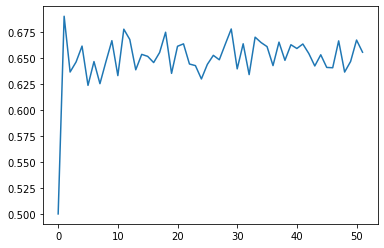

hello


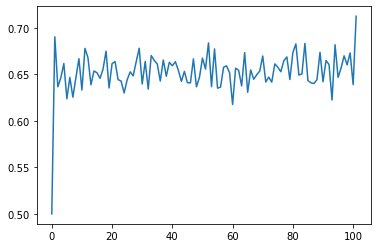

hello


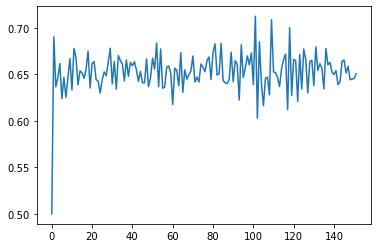

0.6741708874349523

In [13]:
beta = np.array([np.sin(np.pi / 4), np.cos(np.pi / 4)]).reshape(2, 1)
q = 0.8

agent_dist.quantile_fixed_point_iteration(beta, sigma=0.35, q=q, plot=True)


In [14]:
agent_dist.quantile_fixed_point_polyfit(beta, sigma=0.35, q=q)

0.6467006742510133

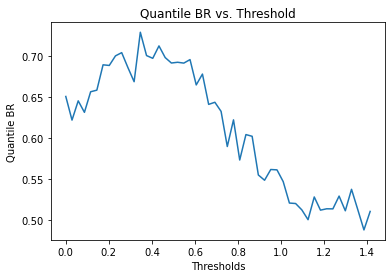

In [15]:
agent_dist.plot_quantile_best_response(beta, sigma=0.35, q=q)